In [1]:
import pandas as pd
import pysam
from Bio.Seq import Seq
import gpplot
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from poola import core as pool

In [2]:
file_path = '../../Data/externalData/'

In [3]:
#read in guide information and read counts
nunez_tiling_sgrna = pd.read_excel(file_path + '1-s2.0-S0092867421003536-mmc4.xlsx', 
                             sheet_name = 'Tiling protospacers',
                            skiprows = 3, header=0)
nunez_tiling_phenotype = pd.read_excel(file_path + '1-s2.0-S0092867421003536-mmc4.xlsx', 
                             sheet_name = 'CRISPRi-K562',
                            skiprows = 3, header=[0, 1])

In [4]:
nunez_tiling_sgrna.head()

,Unnamed: 0,gene,sequence
0,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT
1,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC
2,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA
3,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG
4,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG


In [5]:
nunez_tiling_sgrna = nunez_tiling_sgrna.rename(columns={'Unnamed: 0': 'ID'})

#how many guides to begin with?
len(nunez_tiling_sgrna)

116085

In [6]:
nunez_tiling_phenotype.head()

Unnamed: 0_level_0   Counts                                     \
                  id T0, Rep1 T0, Rep2 Tfinal, Rep1 Tfinal, Rep2   
0  ACTR6_+_100592059      957      826         1038          788   
1  ACTR6_+_100592060      758      739          945          914   
2  ACTR6_+_100592066      992      698         1021          922   
3  ACTR6_+_100592067      958      849          952         1023   
4  ACTR6_+_100592092      182      148          168          219   

                 Phenotype scores                          
  Tfinal, Rep2.1             Rep1      Rep2 ave_Rep1_Rep2  
0            NaN        -0.001747 -0.036016     -0.018881  
1            NaN         0.017515  0.001070      0.009292  
2            NaN        -0.009000  0.010468      0.000734  
3            NaN        -0.013854 -0.002658     -0.008256  
4            NaN        -0.024057  0.026685      0.001314

In [7]:
#check that number of lines matches
len(nunez_tiling_phenotype)

116085

In [8]:
nunez_tiling_phenotype.columns = [f'{i}-{j}' for i, j in nunez_tiling_phenotype.columns]
nunez_tiling_phenotype = nunez_tiling_phenotype.rename(columns={'Unnamed: 0_level_0-id': 'ID'})

#merge guide info and screening data
nunez_tiling = pd.merge(nunez_tiling_sgrna, nunez_tiling_phenotype, on = 'ID')

In [9]:
nunez_tiling.head()

,ID,gene,sequence,"Counts-T0, Rep1","Counts-T0, Rep2","Counts-Tfinal, Rep1","Counts-Tfinal, Rep2","Counts-Tfinal, Rep2.1",Phenotype scores-Rep1,Phenotype scores-Rep2,Phenotype scores-ave_Rep1_Rep2
0,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT,957,826,1038,788,NaN,-0.001747,-0.036016,-0.018881
1,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC,758,739,945,914,NaN,0.017515,0.001070,0.009292
2,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA,992,698,1021,922,NaN,-0.009000,0.010468,0.000734
3,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG,958,849,952,1023,NaN,-0.013854,-0.002658,-0.008256
4,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG,182,148,168,219,NaN,-0.024057,0.026685,0.001314


In [10]:
nunez_tiling.drop('Counts-Tfinal, Rep2.1', axis=1, inplace=True)
nunez_tiling.columns

Index(['ID', 'gene', 'sequence', 'Counts-T0, Rep1', 'Counts-T0, Rep2',
       'Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2', 'Phenotype scores-Rep1',
       'Phenotype scores-Rep2', 'Phenotype scores-ave_Rep1_Rep2'],
      dtype='object')

In [11]:
# remove nas
nunez_tiling_rm_na = nunez_tiling[['ID','gene','sequence','Phenotype scores-ave_Rep1_Rep2']].dropna().copy()

In [12]:
# remove negative controls
nunez_tiling_rm_nc = nunez_tiling_rm_na[nunez_tiling_rm_na.gene != 'negative_control'].copy()

In [13]:
# extract DNA strand and target coordinate from guide ID
nunez_tiling_rm_nc['strand'] = nunez_tiling_rm_nc.ID.str.split("_").str[1]
nunez_tiling_rm_nc['coord'] = nunez_tiling_rm_nc.ID.str.split("_").str[2]

In [14]:
# guide length?
nunez_tiling_rm_nc.sequence.map(len).value_counts()

20    111504
Name: sequence, dtype: int64

In [15]:
#number of genes targeted?
len(nunez_tiling_rm_nc.gene.unique())

520

In [16]:
#save list of genes to use as input for CRISPick run
pd.DataFrame(nunez_tiling_rm_nc.gene.unique()).to_csv(file_path + 'nunez_gene_set.csv',
                                                     index = False, header = None)

Run CRISPick with list of 520 genes as input and default settings otherwise. Three genes (EFTUD1, QARS, SARS) were invalid due to "multiple genes matching" and were therefore excluded.

In [17]:
#read in CRISPick results
gene_crispick = pd.read_table('../../Data/externalData/nunez-gene-set-sgrna-designs.txt')
gene_crispick.head()

,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Alias,CRISPR Mechanism,Target Domain,Reference Sequence,Strand of Target,...,On-Target Efficacy Score,DHS Score,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes
0,64431,1,9606,64431,ACTR6,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000012.12,+,...,0.7089,0.0,2,23,1.0,1.0,7,1,2,Previously skipped due to: DHS Score < 1.0
1,10939,1,9606,10939,AFG3L2,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000018.10,-,...,0.6733,0.0,2,36,1.0,1.0,16,1,2,Previously skipped due to: DHS Score < 1.0
2,25847,1,9606,25847,ANAPC13,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000003.12,-,...,0.4053,0.0,11,13,1.0,1.0,6,1,2,Previously skipped due to: DHS Score < 1.0
3,51433,1,9606,51433,ANAPC5,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000012.12,-,...,0.3737,1.0,16,12,1.0,1.0,6,1,1,NaN
4,1173,1,9606,1173,AP2M1,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000003.12,+,...,0.3504,1.0,16,28,1.0,1.0,13,1,1,NaN


In [24]:
#remove the three invalid genes
gene_set= pd.read_csv(file_path + 'nunez_gene_set.csv', header = None)
gene_set = gene_set[~gene_set[0].isin(['EFTUD1', 'QARS', 'SARS'])][0].dropna().tolist()
gene_crispick['input gene'] = gene_set

In [29]:
#genes that have different names in CRISPick and the Nunez data
miss_gene = set(gene_set) ^ set(set(gene_crispick['Target Gene Symbol']) & set(gene_set))
#number of genes that have different name in CRISPick and the Nunez data
len(miss_gene)

20

In [32]:
# look at updated gene names
merge_gene_name = gene_crispick[['Target Gene Symbol', 'input gene']].copy()
merge_gene_name[merge_gene_name['input gene'].isin(miss_gene)]

,Target Gene Symbol,input gene
6,ATP5F1B,ATP5B
23,NOPCHAP1,C12orf45
24,RTRAF,C14orf166
28,CARS1,CARS
36,POLR1G,CD3EAP
79,DARS1,DARS
97,UTP25,DIEXF
203,MICOS10-NBL1,MINOS1-NBL1
204,MICOS10,MINOS1
207,NIFK,MKI67IP


In [34]:
#extract chromosome
gene_crispick['chromosome'] = 'chr' + gene_crispick['Reference Sequence'].str.split("_").str[1].str.split(".").str[0].str[4:6].astype(int).astype(str)

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_12306/2939865983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_crispick['chromosome'] = 'chr' + gene_crispick['Reference Sequence'].str.split("_").str[1].str.split(".").str[0].str[4:6].astype(int).astype(str)


In [38]:
#merge gene level CRISPick output (with chromosome) with tiling data
merged_tiling = pd.merge(gene_crispick, nunez_tiling_rm_nc, left_on = 'input gene', right_on = 'gene', how = 'inner')
merged_tiling.head()

,Target Gene Symbol,input gene,Reference Sequence,chromosome,ID,gene,sequence,Phenotype scores-ave_Rep1_Rep2,strand,coord
0,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT,-0.018881,+,100592059
1,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC,0.009292,+,100592060
2,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA,0.000734,+,100592066
3,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG,-0.008256,+,100592067
4,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG,0.001314,+,100592092


In [39]:
#create column of coordinates which can be used as input to liftover tool
merged_tiling['liftover'] = merged_tiling['chromosome'] + ':' + merged_tiling['coord'] + '-' + merged_tiling['coord']

In [40]:
merged_tiling['liftover'].to_csv(file_path + 'nunez_guide_coordinates_liftover_input.csv', index = False, header = None)

Run liftover.

In [47]:
# import error file from liftover and remove those coordinates from dataset
err_file = pd.read_table(file_path + 'nunez_liftover_result.err', header = None)
new_merged_tiling = merged_tiling[~merged_tiling['liftover'].isin(err_file[0])]
new_merged_tiling = new_merged_tiling.sort_index().reset_index(drop=True)

In [48]:
#how many coordinates were lost because they aren't present in hg38?
len(err_file)/2

3863.0

In [50]:
# import liftover result
hg38_coord = pd.read_table(file_path + 'nunez_liftover_result.bed', header = None)
hg38_coord.head()

,0
0,chr12:100198281-100198281
1,chr12:100198282-100198282
2,chr12:100198288-100198288
3,chr12:100198289-100198289
4,chr12:100198314-100198314


In [51]:
# split hg38 coordinate to remove unnecessary "end" coordinate, add as column to tiling data
new_merged_tiling['hg38_coord'] = hg38_coord[0].str.split('-').str[1]

### Use an example gene to figure out the coordinates necessary to retrieve guide sequences

In [52]:
# import hg38 genome build
genome = pysam.Fastafile(filename="../../Data/hg38ReferenceGenome/hg38.fa.gz")

In [53]:
new_merged_tiling[new_merged_tiling.gene == 'ACTR6']

,Target Gene Symbol,input gene,Reference Sequence,chromosome,ID,gene,sequence,Phenotype scores-ave_Rep1_Rep2,strand,coord,liftover,hg38_coord
0,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT,-0.018881,+,100592059,chr12:100592059-100592059,100198281
1,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC,0.009292,+,100592060,chr12:100592060-100592060,100198282
2,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA,0.000734,+,100592066,chr12:100592066-100592066,100198288
3,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG,-0.008256,+,100592067,chr12:100592067-100592067,100198289
4,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG,0.001314,+,100592092,chr12:100592092-100592092,100198314
...,...,...,...,...,...,...,...,...,...,...,...,...
300,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_-_100596971,ACTR6,Gtgctcacctcttgctatga,0.011320,-,100596971,chr12:100596971-100596971,100203193
301,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_-_100596976,ACTR6,Gacctcttgctatgaaggct,0.004392,-,100596976,chr12:100596976-100596976,100203198
302,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_-_100597024,ACTR6,Gggaccacaagccctgcggt,-0.012665,-,100597024,chr12:100597024-100597024,100203246
303,ACTR6,ACTR6,NC_000012.12,chr12,ACTR6_-_100597025,ACTR6,Ggaccacaagccctgcggtt,-0.003330,-,100597025,chr12:100597025-100597025,100203247


In [57]:
pos_strand_ex = genome.fetch("chr12", 100198281+3 , 100198281 +22)
seq = Seq(pos_strand_ex)
print(seq.reverse_complement())

CGAGCACATAGAGGGATCT


If the strand is positive, then start at coord + 3 and end at coord + 22.

In [59]:
#if strand is -
# then start: coord - 21 | end: coord - 2
neg_strand_ex = genome.fetch("chr12", 100203198 - 21, 100203198 - 2)
print(neg_strand_ex)

acctcttgctatgaaggct


If the strand is negative, then start at coord - 21 and end at coord - 2.

### Apply to entire dataset to retrieve context sequences

In [60]:
#remove prepended G from guid sequence
new_merged_tiling['seq_remove_g'] = new_merged_tiling.sequence.str[1:]

In [61]:
#convert all coordinates to ints
new_merged_tiling['hg38_coord'] = new_merged_tiling['hg38_coord'].astype(int)

In [63]:
start_coords = []
end_coords = []
guide_inx_mismatch = []
context_seq = []
for index, row in new_merged_tiling.iterrows():
    if row['strand'] == '+':
        start = row['hg38_coord'] + 3
        end = row['hg38_coord'] + 22
        start_coords.append(start)
        end_coords.append(end)
        pos_strand_ex = genome.fetch(row['chromosome'], start , end)
        seq = Seq(pos_strand_ex)
        reverse_comp_strand = seq.reverse_complement()
        
        if reverse_comp_strand.upper() != row['seq_remove_g'].upper():
            print('wrong matching; need to fix something')
            print(reverse_comp_strand)
            print(row['seq_remove_g'])
            guide_inx_mismatch.append(index)
    if row['strand'] == '-':
        start = row['hg38_coord'] - 21
        end = row['hg38_coord'] - 2
        start_coords.append(start)
        end_coords.append(end)
        pos_strand_ex = genome.fetch(row['chromosome'], start , end)
        if pos_strand_ex.upper() != row['seq_remove_g'].upper():
            print('wrong matching; need to fix something')
            print(pos_strand_ex)
            print(row['seq_remove_g'])
            guide_inx_mismatch.append(index)

wrong matching; need to fix something
AATGGACTATCGCTTGATT
GATGGACTATCGCTTGATT
wrong matching; need to fix something
TCACCGTGCCAAGGACGAA
TCACCGTGCCAAGGACGGA
wrong matching; need to fix something
GCGATAGTCCATTCGTCCT
GCGATAGTCCATCCGTCCT
wrong matching; need to fix something
AGTCCATTCGTCCTTGGCA
AGTCCATCCGTCCTTGGCA
wrong matching; need to fix something
TCCCGGCTGTccgcgacgt
TCCCCGCTGTccgcgacgt
wrong matching; need to fix something
CTCCCGGCTGTccgcgacg
CTCCCCGCTGTccgcgacg
wrong matching; need to fix something
acccacgtcgcggACAGCC
acccacgtcgcggACAGCG
wrong matching; need to fix something
cacgtcgcggACAGCCGGG
cacgtcgcggACAGCGGGG
wrong matching; need to fix something
acgtcgcggACAGCCGGGA
acgtcgcggACAGCGGGGA
wrong matching; need to fix something
CACTTGGACACCCGTGGCC
CACATGGACACCCGTGGCC
wrong matching; need to fix something
CGGCGCACTTGGACACCCG
CGGCGCACATGGACACCCG
wrong matching; need to fix something
TGGGGGAGGCCGGCGCACT
TGGGGGAGGCCGGCGCACA
wrong matching; need to fix something
TACTGTGCCCAAGGGACCG
TATTGT

In [67]:
#for how many guides was an incorrect sequence retrieved?
len(guide_inx_mismatch)

507

In [69]:
#how many guides were correctly recovered?
len(new_merged_tiling)-len(guide_inx_mismatch)

106590

In [70]:
#add columns for the start and end coordinates of the guide sequence
new_merged_tiling['start_coord_hg38'] = start_coords
new_merged_tiling['end_coord_hg38'] = end_coords

In [71]:
# remove guides which weren't correctly retrieved
new_merged_tiling = new_merged_tiling.drop(guide_inx_mismatch)

The 30 nt context sequence includes an additional 5 nt on the 5' end and 6 nt on the 3' end; coordinates to fetch need to be adjusted accordingly.

In [74]:
context_seq = []
ngg_check = []
for index, row in new_merged_tiling.iterrows():
    if row['strand'] == '+':
        pos_strand_ex = genome.fetch(row['chromosome'], row['start_coord_hg38'] - 6 , row['end_coord_hg38'] +5 )
        seq = Seq(pos_strand_ex)
        reverse_comp_strand = seq.reverse_complement()
        context_seq.append(str(reverse_comp_strand))
        ngg_check.append(reverse_comp_strand[25:27].upper() == 'GG')
    if row['strand'] == '-':
        pos_strand_ex = genome.fetch(row['chromosome'], row['start_coord_hg38'] - 5 , row['end_coord_hg38'] +6 )
        context_seq.append(pos_strand_ex)
        ngg_check.append(pos_strand_ex[25:27].upper() == 'GG')

In [75]:
#check that PAM is present at the correct position in the context sequence
sum([item[25:27].upper() != 'GG' for item in context_seq])

4

In [77]:
#take a look at the 4 sequences for which there isn't a PAM at the expected location
[item for item in context_seq if item[25:27].upper() != 'GG']

['TCCCGGCAGTCACCGTGCCAAGGACGAATG',
 'tgagagcacccacgtcgcggACAGCCGGGA',
 'CTGGCAAGCACGCCTCCAAAAAGAAGAGCC',
 'TGGCAAGCACGCCTCCAAAAAGAAGAGCCA']

In [79]:
#add list of extracted context sequences and list of boolean values stating whether PAM was found as columns
new_merged_tiling['context_seq'] = context_seq
new_merged_tiling['ngg_check'] = ngg_check

In [81]:
#guides for which context sequence doesn't contain PAM in correct position
new_merged_tiling[new_merged_tiling['ngg_check'] == False]

,Target Gene Symbol,input gene,Reference Sequence,chromosome,ID,gene,sequence,Phenotype scores-ave_Rep1_Rep2,strand,coord,liftover,hg38_coord,seq_remove_g,start_coord_hg38,end_coord_hg38,context_seq,ngg_check
4633,BMS1,BMS1,NC_000010.11,chr10,BMS1_+_43277860,BMS1,GGCAGTCACCGTGCCAAGGA,0.008941,+,43277860,chr10:43277860-43277860,42782412,GCAGTCACCGTGCCAAGGA,42782415,42782434,TCCCGGCAGTCACCGTGCCAAGGACGAATG,False
17300,CPSF1,CPSF1,NC_000008.11,chr8,CPSF1_-_145634372,CPSF1,GgcacccacgtcgcggACAG,0.000552,-,145634372,chr8:145634372-145634372,144408988,gcacccacgtcgcggACAG,144408967,144408986,tgagagcacccacgtcgcggACAGCCGGGA,False
67002,PSMB5,PSMB5,NC_000014.9,chr14,PSMB5_-_23504237,PSMB5,GAAGCACGCCTCCAAAAAGA,0.011927,-,23504237,chr14:23504237-23504237,23035028,AAGCACGCCTCCAAAAAGA,23035007,23035026,CTGGCAAGCACGCCTCCAAAAAGAAGAGCC,False
67003,PSMB5,PSMB5,NC_000014.9,chr14,PSMB5_-_23504238,PSMB5,GAGCACGCCTCCAAAAAGAA,0.014245,-,23504238,chr14:23504238-23504238,23035029,AGCACGCCTCCAAAAAGAA,23035008,23035027,TGGCAAGCACGCCTCCAAAAAGAAGAGCCA,False


In [82]:
# remove those guides
new_merged_tiling = new_merged_tiling[new_merged_tiling['ngg_check'] == True]

In [84]:
# are there any context sequences which map to multiple points in the same gene?
new_merged_tiling[new_merged_tiling[['Target Gene Symbol', 'context_seq']].duplicated(keep = False)]

,Target Gene Symbol,input gene,Reference Sequence,chromosome,ID,gene,sequence,Phenotype scores-ave_Rep1_Rep2,strand,coord,liftover,hg38_coord,seq_remove_g,start_coord_hg38,end_coord_hg38,context_seq,ngg_check


In [86]:
# are there any context sequences which map to multiple genes?
dupliated_df = new_merged_tiling[new_merged_tiling[['context_seq']].duplicated(keep = False)]
dupliated_df

,Target Gene Symbol,input gene,Reference Sequence,chromosome,ID,gene,sequence,Phenotype scores-ave_Rep1_Rep2,strand,coord,liftover,hg38_coord,seq_remove_g,start_coord_hg38,end_coord_hg38,context_seq,ngg_check
4229,BGLAP,BGLAP,NC_000001.11,chr1,BGLAP_+_156181790,BGLAP,GAAGAGATCAAGATGGGCAG,-0.005635,+,156181790,chr1:156181790-156181790,156211999,AAGAGATCAAGATGGGCAG,156212002,156212021,CCTCAAAGAGATCAAGATGGGCAGTGGTGG,True
4230,BGLAP,BGLAP,NC_000001.11,chr1,BGLAP_+_156181796,BGLAP,GCCCTCAAAGAGATCAAGAT,0.015476,+,156181796,chr1:156181796-156181796,156212005,CCCTCAAAGAGATCAAGAT,156212008,156212027,GAAAACCCTCAAAGAGATCAAGATGGGCAG,True
4231,BGLAP,BGLAP,NC_000001.11,chr1,BGLAP_+_156181797,BGLAP,GACCCTCAAAGAGATCAAGA,0.009682,+,156181797,chr1:156181797-156181797,156212006,ACCCTCAAAGAGATCAAGA,156212009,156212028,GGAAAACCCTCAAAGAGATCAAGATGGGCA,True
4232,BGLAP,BGLAP,NC_000001.11,chr1,BGLAP_+_156181852,BGLAP,GTCTTGACAAAGTGCAGGAA,0.014288,+,156181852,chr1:156181852-156181852,156212061,TCTTGACAAAGTGCAGGAA,156212064,156212083,GACTCTCTTGACAAAGTGCAGGAAGGGATA,True
4233,BGLAP,BGLAP,NC_000001.11,chr1,BGLAP_+_156181853,BGLAP,GCTCTTGACAAAGTGCAGGA,0.015981,+,156181853,chr1:156181853-156181853,156212062,CTCTTGACAAAGTGCAGGA,156212065,156212084,GGACTCTCTTGACAAAGTGCAGGAAGGGAT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104376,WDR12,WDR12,NC_000002.12,chr2,WDR12_-_203777023,WDR12,GCGCATTATGCTGGTCTCCA,-0.179443,-,203777023,chr2:203777023-203777023,202912300,CGCATTATGCTGGTCTCCA,202912279,202912298,GCCTGCGCATTATGCTGGTCTCCATGGCGG,True
104377,WDR12,WDR12,NC_000002.12,chr2,WDR12_-_203777027,WDR12,GTTATGCTGGTCTCCATGGC,-0.002317,-,203777027,chr2:203777027-203777027,202912304,TTATGCTGGTCTCCATGGC,202912283,202912302,GCGCATTATGCTGGTCTCCATGGCGGGGCC,True
104378,WDR12,WDR12,NC_000002.12,chr2,WDR12_-_203777028,WDR12,GTATGCTGGTCTCCATGGCG,-0.036299,-,203777028,chr2:203777028-203777028,202912305,TATGCTGGTCTCCATGGCG,202912284,202912303,CGCATTATGCTGGTCTCCATGGCGGGGCCT,True
104379,WDR12,WDR12,NC_000002.12,chr2,WDR12_-_203777342,WDR12,GGCCTTTTCGGGGTCCCACA,-0.001642,-,203777342,chr2:203777342-203777342,202912619,GCCTTTTCGGGGTCCCACA,202912598,202912617,TGGGGGCCTTTTCGGGGTCCCACATGGCAC,True


In [87]:
#look at an example
dupliated_df[dupliated_df.context_seq == 'CCTCAAAGAGATCAAGATGGGCAGTGGTGG']

,Target Gene Symbol,input gene,Reference Sequence,chromosome,ID,gene,sequence,Phenotype scores-ave_Rep1_Rep2,strand,coord,liftover,hg38_coord,seq_remove_g,start_coord_hg38,end_coord_hg38,context_seq,ngg_check
4229,BGLAP,BGLAP,NC_000001.11,chr1,BGLAP_+_156181790,BGLAP,GAAGAGATCAAGATGGGCAG,-0.005635,+,156181790,chr1:156181790-156181790,156211999,AAGAGATCAAGATGGGCAG,156212002,156212021,CCTCAAAGAGATCAAGATGGGCAGTGGTGG,True
61481,PMF1-BGLAP,PMF1-BGLAP,NC_000001.11,chr1,PMF1-BGLAP_+_156181790,PMF1-BGLAP,GAAGAGATCAAGATGGGCAG,-0.005635,+,156181790,chr1:156181790-156181790,156211999,AAGAGATCAAGATGGGCAG,156212002,156212021,CCTCAAAGAGATCAAGATGGGCAGTGGTGG,True
61663,PMF1,PMF1,NC_000001.11,chr1,PMF1_+_156181790,PMF1,GAAGAGATCAAGATGGGCAG,-0.005635,+,156181790,chr1:156181790-156181790,156211999,AAGAGATCAAGATGGGCAG,156212002,156212021,CCTCAAAGAGATCAAGATGGGCAGTGGTGG,True


Duplicates context sequences likely arise from sequence similarity across genes, and are best removed for the purposes of analyzing properties influencing guide activity to avoid ambiguity in target properties.

In [88]:
# drop duplicates and only keep the first one
new_merged_tiling = new_merged_tiling.drop_duplicates(['context_seq'], keep = 'first')
new_merged_tiling= new_merged_tiling[['ID','Target Gene Symbol', 'chromosome','strand','sequence', 'context_seq','hg38_coord', 'start_coord_hg38',
       'end_coord_hg38','Phenotype scores-ave_Rep1_Rep2']]

### Calculate Z-Scores

In [89]:
# remove guides with low representation in pDNA
lognorms_nunez_tiling = pool.lognorm_columns(reads_df=nunez_tiling, columns=['Counts-T0, Rep1', 'Counts-T0, Rep2', 
                                                                          'Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2'])
filtered_lognorms_nunez_tiling = pool.filter_pdna(lognorm_df=lognorms_nunez_tiling, 
                                                  pdna_cols=['Counts-T0, Rep1', 'Counts-T0, Rep2'], z_low=-3)
print('Filtered ' + str(lognorms_nunez_tiling.shape[0] - filtered_lognorms_nunez_tiling.shape[0]) + ' rows due to low pDNA abundance')

Filtered 856 rows due to low pDNA abundance


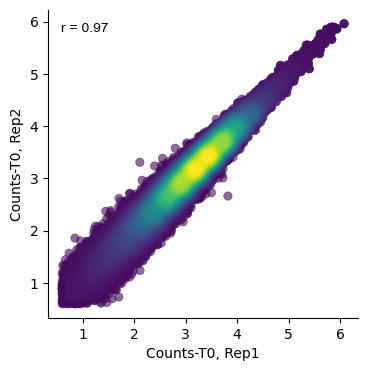

In [95]:
# Assess correlation between pDNA replicates
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=filtered_lognorms_nunez_tiling, x='Counts-T0, Rep1', y='Counts-T0, Rep2')
gpplot.add_correlation(data=filtered_lognorms_nunez_tiling, x='Counts-T0, Rep1', y='Counts-T0, Rep2')
sns.despine()

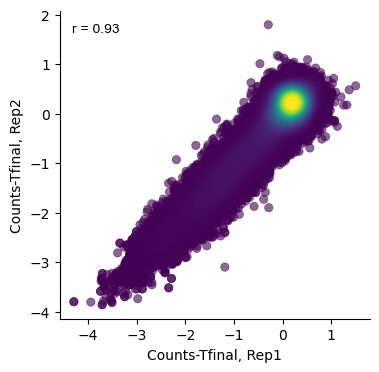

In [96]:
# Find average T0 lognorms because they correlate well
filtered_lognorms_nunez_tiling['Avg Counts-T0'] = filtered_lognorms_nunez_tiling[['Counts-T0, Rep1', 'Counts-T0, Rep2']].mean(axis=1)
# calcuate LFC for final timepoints relative to the averaged T0 lognmorm 
lfc_nunez_tiling = pool.calculate_lfcs(lognorm_df=filtered_lognorms_nunez_tiling, 
                                         ref_col='Avg Counts-T0', 
                                       target_cols=['Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2'])
# check LFC correlations between final timepoint replicates 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_nunez_tiling, x='Counts-Tfinal, Rep1', y='Counts-Tfinal, Rep2')
gpplot.add_correlation(data=lfc_nunez_tiling, x='Counts-Tfinal, Rep1', y='Counts-Tfinal, Rep2')
sns.despine()

In [99]:
# Average final time point LFCs since they correlate well
lfc_nunez_tiling['Avg_LFC-Tfinal'] = lfc_nunez_tiling[['Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2']].mean(axis=1)
# calcuate z-score relative to negative controls
nc_mean = lfc_nunez_tiling[lfc_nunez_tiling.gene == 'negative_control']['Avg_LFC-Tfinal'].mean()
nc_mean_std = lfc_nunez_tiling[lfc_nunez_tiling.gene == 'negative_control']['Avg_LFC-Tfinal'].std()
lfc_nunez_tiling['z-score relative to NC'] = (lfc_nunez_tiling['Avg_LFC-Tfinal'] - nc_mean)/nc_mean_std

In [100]:
lfc_nunez_tiling_cleaned = lfc_nunez_tiling.dropna()
lfc_nunez_tiling_cleaned = lfc_nunez_tiling_cleaned[['ID', 'gene', 'sequence','Phenotype scores-ave_Rep1_Rep2',
       'Avg_LFC-Tfinal', 'z-score relative to NC']]
lfc_nunez_tiling_cleaned

,ID,gene,sequence,Phenotype scores-ave_Rep1_Rep2,Avg_LFC-Tfinal,z-score relative to NC
0,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT,-0.018881,0.035104,-0.889828
1,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC,0.009292,0.295731,0.580559
2,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA,0.000734,0.214023,0.119582
3,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG,-0.008256,0.131427,-0.346402
4,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG,0.001314,0.165469,-0.154343
...,...,...,...,...,...,...
116080,i_non-targeting_03785,negative_control,GCTACTCCGCCCCGCGGGAG,-0.011636,0.093847,-0.558412
116081,i_non-targeting_03786,negative_control,GTGGCCGTTCATGGGACCGG,-0.007025,0.139098,-0.303121
116082,i_non-targeting_03787,negative_control,GAACTCTGTAGAAGGGACCG,0.021469,0.387211,1.096662
116083,i_non-targeting_03788,negative_control,GCTCGACAGCGACTGAAGAG,-0.042726,-0.170976,-2.052470


In [101]:
# check if guide IDs are unique before merging on that column
lfc_nunez_tiling_cleaned['ID'].value_counts()

ACTR6_+_100592059        1
RPF1_+_84945864          1
RPF2_+_111303126         1
RPF2_+_111303113         1
RPF2_+_111303093         1
                        ..
IMPDH2_-_49066263        1
IMPDH2_-_49066262        1
IMPDH2_-_49066252        1
IMPDH2_-_49066251        1
i_non-targeting_03789    1
Name: ID, Length: 115115, dtype: int64

In [102]:
final_clean = pd.merge(new_merged_tiling, 
         lfc_nunez_tiling_cleaned.rename(columns = {'gene': 'Target Gene Symbol'}), 
         on = ['ID', 'Target Gene Symbol', 'sequence','Phenotype scores-ave_Rep1_Rep2'])

final_clean

,ID,Target Gene Symbol,chromosome,strand,sequence,context_seq,hg38_coord,start_coord_hg38,end_coord_hg38,Phenotype scores-ave_Rep1_Rep2,Avg_LFC-Tfinal,z-score relative to NC
0,ACTR6_+_100592059,ACTR6,chr12,+,GCGAGCACATAGAGGGATCT,TGCTTCGAGCACATAGAGGGATCTGGGCCC,100198281,100198284,100198303,-0.018881,0.035104,-0.889828
1,ACTR6_+_100592060,ACTR6,chr12,+,GTCGAGCACATAGAGGGATC,CTGCTTCGAGCACATAGAGGGATCTGGGCC,100198282,100198285,100198304,0.009292,0.295731,0.580559
2,ACTR6_+_100592066,ACTR6,chr12,+,GCCTGCTTCGAGCACATAGA,GTCCACCTGCTTCGAGCACATAGAGGGATC,100198288,100198291,100198310,0.000734,0.214023,0.119582
3,ACTR6_+_100592067,ACTR6,chr12,+,GACCTGCTTCGAGCACATAG,GGTCCACCTGCTTCGAGCACATAGAGGGAT,100198289,100198292,100198311,-0.008256,0.131427,-0.346402
4,ACTR6_+_100592092,ACTR6,chr12,+,GAGACTCTGTCACCTCCGAG,GGGCTAGACTCTGTCACCTCCGAGGGGTCC,100198314,100198317,100198336,0.001314,0.165469,-0.154343
...,...,...,...,...,...,...,...,...,...,...,...,...
96841,ZNHIT6_-_86174780,ZNHIT6,chr1,-,GACCCTTACACTCTGGAAAT,GCGAAACCCTTACACTCTGGAAATGGGAAA,85709097,85709076,85709095,-0.008738,0.108648,-0.474910
96842,ZNHIT6_-_86174954,ZNHIT6,chr1,-,Gataatatgagatcatgcat,cgaagataatatgagatcatgcataggaat,85709271,85709250,85709269,0.006646,0.259214,0.374536
96843,ZNHIT6_-_86174996,ZNHIT6,chr1,-,Gcacaaactcagtgtataac,acagacacaaactcagtgtataactggGAA,85709313,85709292,85709311,-0.018978,0.021910,-0.964261
96844,ZNHIT6_-_86174997,ZNHIT6,chr1,-,Gacaaactcagtgtataact,cagacacaaactcagtgtataactggGAAT,85709314,85709293,85709312,0.048488,0.601063,2.303151


In [103]:
final_clean.to_csv(file_path + 'Nunez2021Cleaned.csv',index = False)